# Investigating fluxes of stratification at the Weddell Sea mooring plume

Rowan Brown | 26.02.2025

This notebook is for exploring profiles at the Weddell Sea mooring in terms of stratifiation fluxes. In other words, its to investigate how to create initial conditions (for the MITgcm plume simulation) that reflect the stratification at the mooring in the Weddell Sea, *combined* with estimates of surface heat and salt fluxes, which recreate the observed plume.

First, some imports:

In [3]:
import numpy as np
import pandas as pd
import xmitgcm
import matplotlib.pylab as plt
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot
import xmitgcm.file_utils
import xmitgcm.utils
from MITgcmutils import density
import xarray as xr
import gsw

import sys
sys.path.insert(1, '../obs_analyses/')
import mooring_analyses
import woa_analyses

## Initial condition stability

Here, we're going to look at salinity and temperature profiles, as used in the model, along with potential density or buoyancy frequency. The result will show how stable a certain combination of temperature and salinity initial conditions end up being. Note that salinities are absolute and temperatures are potential, since this is what *eosType=TEOS10* uses in MITgcm.

2.2851061237203275e-07
-1.5525375634252156e-05
2.439073304385744e-07
-6.86589183977212e-07


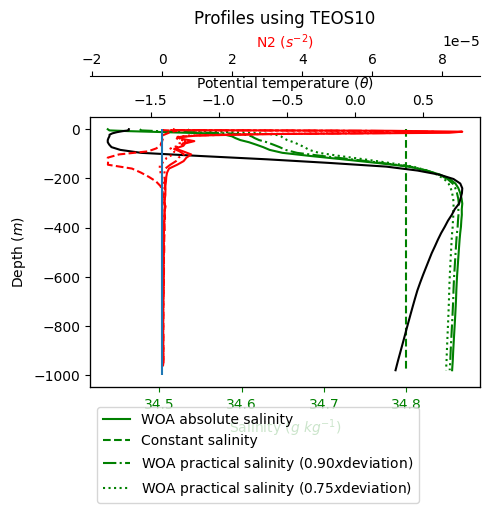

In [36]:
# Opening init binaries 
open_bin = lambda f : xmitgcm.utils.read_raw_data('../MITgcm/so_plumes/binaries/'+f, shape=(50,100,100), dtype=np.dtype('>f4') )

# Opening mds binary to get model depths
ds = xmitgcm.open_mdsdataset('/albedo/home/robrow001/MITgcm/so_plumes/mrb_027/',   geometry='cartesian',   prefix=['S','T'], iters=[0])
depths = ds['Z'].values

# Binary names and plotting dictionaries
files  = ['SA.WOA2015.50x100x100.autumn.bin', 'S.const34.8.50x100x100.bin', 'SAx090.WOA2015.50x100x100.autumn.bin', 
          'SAx075.WOA2015.50x100x100.autumn.bin', 'theta.WOA2015.50x100x100.autumn.bin']
legend = {'SA.WOA2015.50x100x100.autumn.bin': 'WOA absolute salinity', 
          'S.const34.8.50x100x100.bin': 'Constant salinity',
          'SAx090.WOA2015.50x100x100.autumn.bin': 'WOA practical salinity (0.90$x$deviation)',
          'SAx075.WOA2015.50x100x100.autumn.bin': 'WOA practical salinity (0.75$x$deviation)',
          'theta.WOA2015.50x100x100.autumn.bin': 'WOA potential temperature'}
lines  = {'SA.WOA2015.50x100x100.autumn.bin': 'solid',
          'S.const34.8.50x100x100.bin': 'dashed',
          'SAx090.WOA2015.50x100x100.autumn.bin': 'dashdot',
          'SAx075.WOA2015.50x100x100.autumn.bin': 'dotted',
          'theta.WOA2015.50x100x100.autumn.bin': 'solid'}

#== Plotting ==#
fig, ax = plt.subplots(figsize=(5,6))
ax.set_ylabel('Depth ($m$)')

# Salinity
ax.set_xlabel('Salinity ($g$ $kg^{-1}$)')
for f in files[:-1]: 
    ax.plot(open_bin(f)[:,50,50],depths,label=legend[f],ls=lines[f],c='g')
ax.xaxis.label.set_color('g')
ax.tick_params(axis='x', colors='g')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.25))

# Temperature
ax2 = ax.twiny()
ax2.set_xlabel(r'Potential temperature ($\theta$)')
f = files[-1]
theta_profile = open_bin(f)[:,50,50]
ax2.plot(theta_profile,depths,label=legend[f],ls=lines[f],c='k')

# Potential density OR N**2 (dealer's choice)
ax3 = ax.twiny()
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('N2 ($s^{-2}$)')#Potential density ($kg$ $m^{-3}$)')
for f in files[:-1]:
    SA = open_bin(f)[:,50,50]
    CT = gsw.CT_from_pt(SA,theta_profile)
    N2, p_mid = gsw.Nsquared(SA,CT,gsw.p_from_z(depths,-69.0005),-69.0005)
    ax3.plot(N2,gsw.z_from_p(p_mid,-69.0005),label=legend[f],ls=lines[f],c='r')
    print(min(N2))
ax3.xaxis.label.set_color('r')
ax3.tick_params(axis='x', colors='k')
ax3.vlines(0,-1000,0)

plt.title('Profiles using TEOS10')
plt.tight_layout()

## Fluxes of stratification

From above, we now have a way to verify the stability of our initial conditions. So, the next step is to roughly estimate how much heat and salt flux occured through the surface at the mooring. 

### A couple observations:
* For now, consider that sea water temperature cannot go below -1.8. If the temperature at 50 m is -1.8, in the autumn runs (N.H. autumn, so S.H. spring), then the whole surface above 50 m is likely also at -1.8. (Consider (a) that we're assuming a surface-driven plume; hence homogenised/cold/as-dense-as-can-be, and (b) the autumn WOA climatology is relatively homogenous; only the summer has a pronounced subsurface cold layer)
* Salinity in the WOA climatologies *for all seasons* is fresher at the surface than at 50 m; in the autumn it is ~0.1 PSU less at the surface than at 25 m, with a very steep halocline. Another less steep halocline exists at 125 m. In a spring plume with breaking up sea ice, this is what we might expect. However, if the ice is breaking up due to wind coupled with intense *cooling*, i.e., a cold springtime storm, which explains the ostensibly heat-flux-driven plume, then perhaps there would be less melt, less of a freshwater cap, and maybe even continued brine rejection. I can think of no strong argument against this case, and hence I will assume that the salinity above 50 m is the same as at 50 m, just like with the temperature.

### Calculating heat content and flux
Heat content in a $1$ m $\times$ $1$ m column of water is calculated by integrating over depth, i.e., 
$$
    HC = \int \rho\ c_p\ T\ dz,
$$
where in this case $c_p$ is the isobaric heat capacity in $J\ kg^{-1}\ ℃^{-1}$ (calculated using gsw_cp_t_exact), $\rho$ is the in-situ (I think) density in $kg\ m^{-3}$, and $T$ is in-situ (I think) temperature in $℃$. Integrating over depth (and the $1$ m $\times$ $1$ m column) gives units of $J$. We *could* using $T-T_{ref}$ but I don't see a good argument why, especially since we're only interested in the general rate of change of heat content. HF is HC derived over time, i.e., 
$$
    HF = \frac{d\ HC}{dt} 
$$

### Calculating salt content and flux
Similar calculations to heat flux, except the total salt content is found by simply multiplying the salinity by the density. In other words,
$$
    SC = \int \rho\ S\  dz \rightarrow SF = \frac{d\ SC}{dt},
$$
where the unit of salt content is *g* (consider, $\rho [kg/m^3]\ S[g/kg]$) and the unit of salt flux is *g* per day.

In [7]:
# Opening the mooring data
ds = mooring_analyses.open_mooring_ml_data()
ds = mooring_analyses.correct_mooring_salinities(ds)

# Adding "cell" thicknesses associated with each of the 3 active sensors
dz = [(135-50)/2,np.nan,(135-50)/2+(220-135)/2,np.nan,(220-135)/2,np.nan]
ds = ds.assign_coords(dz=("depth",dz))

# Calculating the quantity of heat in the water column
ds['cp'] = gsw.cp_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # Isobaric cp 
ds['rho'] = gsw.rho_t_exact(ds['SA'],ds['T'],ds['p_from_z']) # In-situ density
ds['HC'] = (ds['rho']*ds['cp']*ds['T']*ds['dz']).sum(dim='depth') # Unit: J
ds['HF'] = ds['HC'].differentiate('day',datetime_unit="D") # Unit: J/day

# Calculating the quantity of salt in the water column
ds['SC'] = (ds['SA']*ds['rho']*ds['dz']).sum(dim='depth') # Unit: g
ds['SF'] = ds['SC'].differentiate('day',datetime_unit="D") # Unit: J/day

Mooring data opened
 50 m 12-month mean from mooring: 34.369026312739166
 50 m 12-month mean from WOA:     34.38139177087235
Difference: -0.012365458133182017

135 m 12-month mean from mooring: 34.62643276987689
135 m 12-month mean from WOA:     34.61529681898143
Difference: 0.01113595089546493

220 m 12-month mean from mooring: 34.65634859275297
220 m 12-month mean from WOA:     34.69025839191593
Difference: -0.033909799162962884
Salinities corrected


### Plotting

Text(0.5, 1.0, 'Heat (blue) and salt (green) fluxes over time')

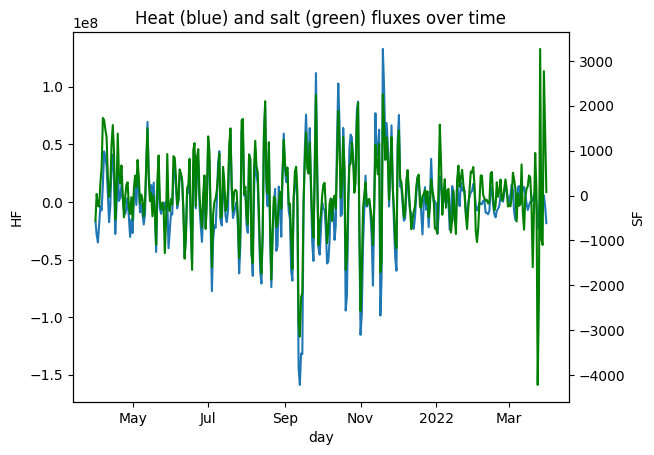

In [19]:
fig,ax = plt.subplots()
ds['HF'].plot(ax=ax)
ax2 = ax.twinx()
ds['SF'].plot(ax=ax2,c='g')
plt.title('Heat (blue) and salt (green) fluxes over time')


### Minimum heat flux

In [17]:
print(ds['HF'].min()/(24*60*60)) # Unit: W/m**2

<xarray.DataArray 'HF' ()> Size: 8B
array(-1838.67366831)


## Conclusion

I believe salt content / brine rejection come into play by densifying the surface throughout the winter and eroding stratification. Then a pulse of heat loss causes rapid sinking. Immediately afterwards, there is a negative flux of salt associated with fresh and cold surface water moving down; we don't see warm/salty CDW coming up in this dataset due to the location and vertical/time fidelity, but we probably will see it in the vicinity of the plume in the model. Hence I will force the model with the surface heat flux (roughly based on the values from here) but NOT surface salt flux; the inner-plume salinity is dominated by sea water dynamics, not some kind of rapid ice pulse (again: ice processes come into play by affecting the pre-stratification so that a plume can be triggered by HF). Also note that the surface heat flux in the spring "storm" (or whatever caused it) is likely much stronger than shown here since this integrated calculation likely accounts for some warm water coming up over the course of the day. 